### CODE WRITTEN ON 05/15/2024

This code takes the input data matrix X, the desired rank r, the step size parameter theta, and the maximum number of iterations max_iter as inputs. The algorithm initializes U as an identity matrix and V as a zero matrix. It then iteratively updates each column of U using the update rules provided, with the center mu chosen as the mean of a random subset of columns of X. After updating U, it solves for V using least squares and enforces non-negativity.

The example usage generates random data in R^3, runs the Cone Collapsing algorithm, and visualizes the data points and the learned vertex rays in a 3D plot using Matplotlib.

This is a basic implementation that I threw together with a fried brain after finals and will need further optimization and tuning for real-world applications. We should experiment with different values of theta, max_iter, and the size of the random subset used for choosing the center mu to see how they affect the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Button
%matplotlib widget

In [2]:
def cone_collapsing(X, r, theta, max_iter):
    """
    Cone Collapsing algorithm for NMF

    Parameters:
    X (numpy.ndarray): Input data matrix (m x n)
    r (int): Rank of the factorization
    theta (float): Step size parameter in [0, pi/2]
    max_iter (int): Maximum number of iterations

    Returns:
    U (numpy.ndarray): Left factor matrix (m x r)
    V (numpy.ndarray): Right factor matrix (n x r)
    """
    m, n = X.shape
    U = np.eye(m, r)  # Initialize U as identity matrix
    V = np.zeros((n, r))  # Initialize V as zero matrix

    U_history = [U.copy()]

    for t in range(max_iter):
        for i in range(r):
            ui = U[:, i]
            mu = np.mean(X, axis=1)  # Center towards the mean of all data points
            mu_hat = np.dot(ui, mu) * ui  # Projection of mu onto span(ui)
            mu_perp = mu - mu_hat  # Residual

            if np.linalg.norm(mu_perp) > 1e-10:  # Check if mu_perp is not close to zero
                ui_prime = mu_hat + np.linalg.norm(mu_hat) * np.tan(theta) * mu_perp / np.linalg.norm(mu_perp)
            else:
                ui_prime = mu_hat

            U[:, i] = ui_prime / np.linalg.norm(ui_prime)

        if np.all(np.dot(U.T, X) >= 0):
            U_history.append(U.copy())
        else:
            break

        V = np.linalg.lstsq(U, X, rcond=None)[0]  # Solve for V using least squares
        V[V < 0] = 0  # Enforce non-negativity

    return U, V, U_history

def update_plot(idx):
    ax.clear()
    ax.scatter(X[0], X[1], X[2], c='b', marker='o', label='Data points')

    for i in range(r):
        ui = U_history[idx][:, i]
        ax.quiver(0, 0, 0, ui[0], ui[1], ui[2], color='r', label=f'Vertex ray {i+1}')

    # Draw triangular planes connecting the vertex rays
    for i in range(r):
        j = (i + 1) % r
        ui = U_history[idx][:, i]
        uj = U_history[idx][:, j]

        ax.plot([0, ui[0]], [0, ui[1]], [0, ui[2]], color='g', alpha=0.3)
        ax.plot([0, uj[0]], [0, uj[1]], [0, uj[2]], color='g', alpha=0.3)
        ax.plot([ui[0], uj[0]], [ui[1], uj[1]], [ui[2], uj[2]], color='g', alpha=0.3)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Cone Collapsing in R^3 (Iteration {idx+1})')
    ax.legend()

def on_button_click(event):
    global idx
    idx = (idx + 1) % len(U_history)
    update_plot(idx)
    fig.canvas.draw_idle()

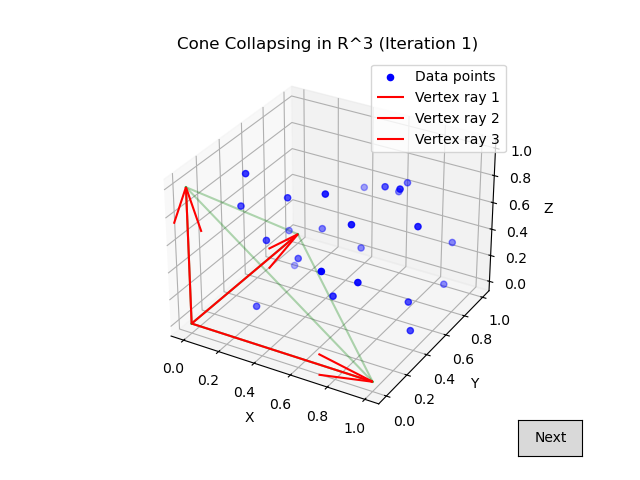

In [3]:
# Example usage in R^3
m, n, r = 3, 25, 3
X = np.random.rand(m, n)  # Generate random data in R^3
theta = np.pi / 12  # Step size parameter
max_iter = 100  # Maximum number of iterations

U, V, U_history = cone_collapsing(X, r, theta, max_iter)

# Visualization in R^3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0], X[1], X[2], c='b', marker='o', label='Data points')

idx = 0
update_plot(idx)

ax_button = plt.axes([0.81, 0.05, 0.1, 0.075])
button = Button(ax_button, 'Next')
button.on_clicked(on_button_click)

plt.show()

### OLD VERSION OF THE CODE

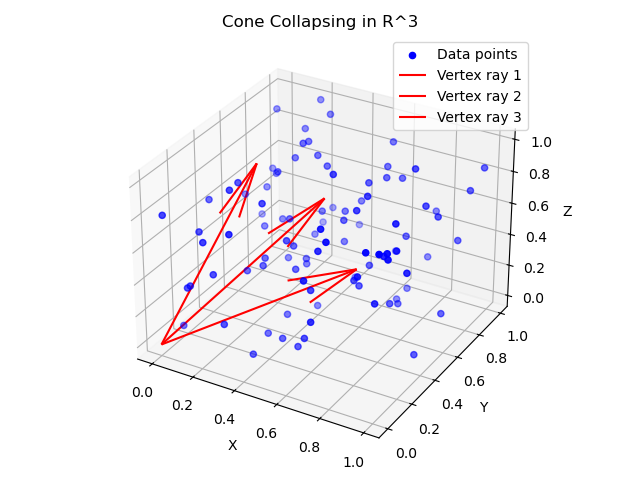

In [4]:
def cone_collapsing(X, r, theta, max_iter):
    """
    Cone Collapsing algorithm for NMF

    Parameters:
    X (numpy.ndarray): Input data matrix (m x n)
    r (int): Rank of the factorization
    theta (float): Step size parameter in [0, pi/2]
    max_iter (int): Maximum number of iterations

    Returns:
    U (numpy.ndarray): Left factor matrix (m x r)
    V (numpy.ndarray): Right factor matrix (n x r)
    """
    m, n = X.shape
    U = np.eye(m, r)  # Initialize U as identity matrix
    V = np.zeros((n, r))  # Initialize V as zero matrix

    for t in range(max_iter):
        for i in range(r):
            ui = U[:, i]
            mu = np.mean(X[:, np.random.choice(n, size=10, replace=False)], axis=1)  # Center towards random subset of columns
            mu_hat = np.dot(ui, mu) * ui  # Projection of mu onto span(ui)
            mu_perp = mu - mu_hat  # Residual

            ui_prime = mu_hat + np.linalg.norm(mu_hat) * np.tan(theta) * mu_perp / np.linalg.norm(mu_perp)
            U[:, i] = ui_prime / np.linalg.norm(ui_prime)

        V = np.linalg.lstsq(U, X, rcond=None)[0]  # Solve for V using least squares
        V[V < 0] = 0  # Enforce non-negativity

    return U, V

# Example usage in R^3
m, n, r = 3, 100, 3
X = np.random.rand(m, n)  # Generate random data in R^3
theta = np.pi / 6  # Step size parameter
max_iter = 100  # Maximum number of iterations

U, V = cone_collapsing(X, r, theta, max_iter)

# Visualization in R^3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0], X[1], X[2], c='b', marker='o', label='Data points')

for i in range(r):
    ui = U[:, i]
    ax.quiver(0, 0, 0, ui[0], ui[1], ui[2], color='r', label=f'Vertex ray {i+1}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cone Collapsing in R^3')
ax.legend()
plt.tight_layout()
plt.show()